<a href="https://colab.research.google.com/github/briansrebrenik/xray_classifier/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.applications import InceptionResNetV2
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline

In [0]:
plt.style.use('ggplot')

In [0]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Colab\ Notebooks/x_ray/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia -p /content --unzip

100% 1.15G/1.15G [00:11<00:00, 77.4MB/s]
100% 1.15G/1.15G [00:11<00:00, 103MB/s] 


In [6]:
!unzip /content/chest_xray.zip && rm /content/chest_xray.zip


Archive:  /content/chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: __MACOSX/chest_xray/t

In [0]:
!rm -rf /content/__MACOSX

In [0]:
test_negative = [x[2] for x in os.walk('/content/chest_xray/test/NORMAL')][0]
test_positive = [x[2] for x in os.walk('/content/chest_xray/test/PNEUMONIA')][0]
train_negative = [x[2] for x in os.walk('/content/chest_xray/train/NORMAL')][0]
train_positive = [x[2] for x in os.walk('/content/chest_xray/train/PNEUMONIA')][0]
val_negative = [x[2] for x in os.walk('/content/chest_xray/val/NORMAL')][0]
val_positive = [x[2] for x in os.walk('/content/chest_xray/val/PNEUMONIA')][0]

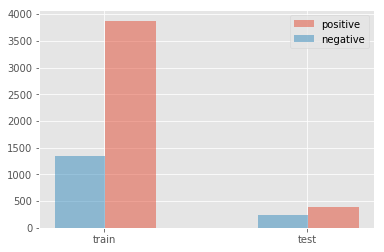

In [9]:
pos = list(range(2))
width = 0.25
fig, ax = plt.subplots() 

plt.bar([p+width for p in pos], height=[len(train_positive), len(test_positive)], width=width, alpha=.5,
       label='positive')

plt.bar(pos, height=[len(train_negative), len(test_negative)], width=width, alpha=.5,
       label='negative')

plt.xticks(ticks=[.12,1.12], labels=['train', 'test'])
plt.legend()
plt.show()

(1, 150, 150, 3)


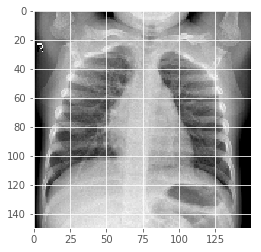

In [10]:
sample_image = train_negative[0]
img = image.load_img(f'/content/chest_xray/train/NORMAL/{sample_image}', target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [12]:
tdg = train_datagen.flow_from_directory(directory='/content/chest_xray/train', 
                                       target_size=(224,224), class_mode='binary',
                                       batch_size=32)

Found 5216 images belonging to 2 classes.


In [13]:
vdg = val_datagen.flow_from_directory(directory='/content/chest_xray/test', 
                                       target_size=(224,224), class_mode='binary',
                                       batch_size=156)


Found 624 images belonging to 2 classes.


In [0]:
base_model = InceptionResNetV2(input_shape=(224, 224, 3), weights= None, 
                        include_top=False)

In [0]:
# base_model.trainable = False

In [27]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [28]:
model = Sequential()
model.add(base_model)
model.add(layers.Dropout(.5))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=adam(lr=.001),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 1536)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_206 (Bat (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 54,534,113
Trainable params: 54,473,313
Non-trainable params: 60,800
___________________________________________________________

In [0]:
checkpoint = ModelCheckpoint(filepath='/content/chest_xray/model.h5', 
                             monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', 
                             save_weights_only = True)

learning = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                             patience=5, verbose=1, 
                             mode="min", min_lr=1e-8)

#early = EarlyStopping(monitor="val_loss", patience=20, mode='min')

callbacks_list = [learning, checkpoint]



In [30]:
history = model.fit_generator(tdg, steps_per_epoch= 40, epochs=100, 
                              validation_data=vdg, callbacks = callbacks_list, 
                              validation_steps=4, workers=2, 
                              use_multiprocessing=True)


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
40/40 [==============================] - 130s 3s/step - loss: 0.4394 - acc: 0.8547 - val_loss: 9.0453 - val_acc: 0.3750

Epoch 00001: val_loss improved from inf to 9.04533, saving model to /content/chest_xray/model.h5
Epoch 2/100
40/40 [==============================] - 33s 820ms/step - loss: 0.2316 - acc: 0.9078 - val_loss: 1.5656 - val_acc: 0.6154

Epoch 00002: val_loss improved from 9.04533 to 1.56559, saving model to /content/chest_xray/model.h5
Epoch 3/100
40/40 [==============================] - 34s 847ms/step - loss: 0.1898 - acc: 0.9344 - val_loss: 1.0505 - val_acc: 0.6314

Epoch 00003: val_loss improved from 1.56559 to 1.05048, saving model to /content/chest_xray/model.h5
Epoch 4/100
40/40 [==============================] - 34s 845ms/step - loss: 0.1672 - acc: 0.9484 - val_loss: 1.4458 - val_acc: 0.6314

Epoch 00004: val_loss did not improve from 1.05048
Epoch 5/100
40/40 [==============================] - 34s 849ms/step - loss: 0.1514 - acc: 0.9469 - val_loss: 0.7

In [0]:
model.load_weights('/content/chest_xray/model.h5')

In [0]:
preds = model.predict_generator(vdg, steps=4, workers=2,
                               use_multiprocessing=True)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:398: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


In [0]:
vdg.

In [0]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      7786
           1       0.00      0.00      0.00       214

    accuracy                           0.97      8000
   macro avg       0.49      0.50      0.49      8000
weighted avg       0.95      0.97      0.96      8000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
